# Import Packages

In [63]:
# Numerical Operations
import numpy as np
import math
from matplotlib import pyplot as plt

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
import torchvision.transforms as transforms

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter


In [64]:
with open('./shakespeare_train.txt', mode='r') as f:
        text = f.read()

text_file = list()
text = ''.join([word for word in list(filter(None, text.splitlines())) if ':' not in word])
text_file += [words for words in text] 

vocab = tuple(set(text))
vocab_to_int = {c:i for i,c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))


def encoding(url):
    with open(url, mode='r') as f:
        text = f.read()
    text_file = list()
    text = ''.join([word for word in list(filter(None, text.splitlines())) if ':' not in word])
    text_file += [words for words in text] 
    encoded = np.array([vocab_to_int[c] for c in text_file])
    return encoded


print(vocab)
print(vocab_to_int)
print(int_to_vocab)

("'", 'y', 'g', 'f', 'h', 'F', 't', 'I', 'N', 'S', 'i', 'X', 'Y', 'C', 'Z', 'z', 'V', '.', ']', 'G', 'l', '&', 'v', 'B', 'n', 'c', '-', '!', 'L', 'm', 'x', 'e', 'r', '3', 'k', 'P', 'W', 'b', 'E', 'o', ',', '[', 'O', 'q', 'j', 'Q', 'd', 'D', ' ', '?', 's', ';', 'u', 'w', 'H', 'R', 'U', 'J', 'A', '$', 'T', 'a', 'K', 'M', 'p')
{"'": 0, 'y': 1, 'g': 2, 'f': 3, 'h': 4, 'F': 5, 't': 6, 'I': 7, 'N': 8, 'S': 9, 'i': 10, 'X': 11, 'Y': 12, 'C': 13, 'Z': 14, 'z': 15, 'V': 16, '.': 17, ']': 18, 'G': 19, 'l': 20, '&': 21, 'v': 22, 'B': 23, 'n': 24, 'c': 25, '-': 26, '!': 27, 'L': 28, 'm': 29, 'x': 30, 'e': 31, 'r': 32, '3': 33, 'k': 34, 'P': 35, 'W': 36, 'b': 37, 'E': 38, 'o': 39, ',': 40, '[': 41, 'O': 42, 'q': 43, 'j': 44, 'Q': 45, 'd': 46, 'D': 47, ' ': 48, '?': 49, 's': 50, ';': 51, 'u': 52, 'w': 53, 'H': 54, 'R': 55, 'U': 56, 'J': 57, 'A': 58, '$': 59, 'T': 60, 'a': 61, 'K': 62, 'M': 63, 'p': 64}
{0: "'", 1: 'y', 2: 'g', 3: 'f', 4: 'h', 5: 'F', 6: 't', 7: 'I', 8: 'N', 9: 'S', 10: 'i', 11: 'X',

In [65]:
encoded_train = encoding('./shakespeare_train.txt')
encoded_valid = encoding('./shakespeare_valid.txt')

print(encoded_train.shape)
print(encoded_valid.shape)

(3365436,)
(171929,)


In [66]:
def one_hot_encode(arr, n_labels):
    one_hot = np.zeros((arr.size, n_labels), dtype = np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot

In [67]:
def get_batches(array, batch_size, seq_length):  # array, batch_size=8, seq_length=50
    batch_size_total = batch_size * seq_length  # 400
    n_batches = len(array) // batch_size_total  
    
    array = array[:n_batches * batch_size_total]
    array = array.reshape((batch_size, -1))
    
    for n in range(0, array.shape[1], seq_length):
        x = array[:, n:n+seq_length]
        y = np.zeros_like(x)
        try:
            y[:,:-1], y[:,-1] = x[:,1:], array[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], array[:, 0]
        yield x, y 

In [68]:
class CharRNN(nn.Module):
    def __init__(self, tokens, n_hidden=256, n_layers=2, drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        self.rnn = nn.RNN(len(self.chars), n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
    def forward(self, x, hidden):
        r_output, hidden = self.rnn(x, hidden)
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = weight.new(self.n_layers, batch_size, self.n_hidden).zero_()
        
        return hidden     


In [71]:
device = 'cuda'

def train(model, train_data, valid_data, epochs=10, batch_size=10, seq_length=50, lr=1e-3, clip=5, val_frac=0.1, print_every=10):
        
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    
    train_data_loader = get_batches(train_data, batch_size, seq_length)
    valid_data_loader = get_batches(valid_data, batch_size, seq_length)
    
    counter_train = 0
    counter_valid = 0

    n_chars = len(model.chars)

    loss_per_epoch_train = list()
    acc_per_epoch_train = list()
    loss_per_epoch_valid = list()
    acc_per_epoch_valid = list()

    train_loss = list()
    train_accuracy = list()
    valid_loss = list()
    valid_accuracy = list()

    model.train()

    for epoch in range(epochs):
        
        h = model.init_hidden(batch_size)

        for x, y in get_batches(train_data, batch_size, seq_length):
            
            counter_train += 1
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)  # one hot -> (128, 100, 65), (128, 100)

            optimizer.zero_grad()
            
            output, h = model(inputs, h) #(12800, 65)

            h = h.detach()
            
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            train_loss.append(loss.detach().item())
            loss.backward()

            p = torch.nn.functional.softmax(output, dim=1).data #(12800, 65)
            a = model.int2char[np.argmax(p[1]).item()] # vocab
            
            
            if model.int2char[targets[0][0].item()] == a:
                train_accuracy.append(0)
            else:
                train_accuracy.append(1)


            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()


            if counter_train % print_every == 0:
                print("Epoch: {}/{}".format(epoch+1, epochs), "Train Step: {}".format(counter_train))
                print("train loss: {:.4f}".format(sum(train_loss) / len(train_loss)))
                print("train acc: {:.4f}".format(sum(train_accuracy) / len(train_accuracy)))


        mean_train_loss = sum(train_loss) / len(train_loss)
        mean_train_acc = sum(train_accuracy) / len(train_accuracy)
        loss_per_epoch_train.append(mean_train_loss)
        acc_per_epoch_train.append(mean_train_acc)
            

        model.eval()
        val_h = model.init_hidden(batch_size)

        for x, y in valid_data_loader:

            counter_valid += 1
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
                                 
            output, val_h = model(inputs, val_h)
            val_h = val_h.detach()

            val_loss = criterion(output, targets.view(batch_size*seq_length).long())

            valid_loss.append(val_loss.item())

            p = torch.nn.functional.softmax(output, dim=1).data #(12800, 65)
            a = model.int2char[np.argmax(p[1]).item()] # vocab

            if model.int2char[targets[0][0].item()] == a:
                valid_accuracy.append(0)
            else:
                valid_accuracy.append(1)


        print("valid loss: {:.4f}".format(sum(valid_loss) / len(valid_loss)))
        print("valid acc: {:.4f}".format(sum(valid_accuracy) / len(valid_accuracy)))


        mean_valid_loss = sum(valid_loss) / len(valid_loss)
        mean_valid_acc = sum(valid_accuracy) / len(valid_accuracy)
        loss_per_epoch_valid.append(mean_valid_loss)
        acc_per_epoch_valid.append(mean_valid_acc)

        model.train()
                
                
        # print("Epoch: {}/{}...".format(epoch+1, epochs),
        #               "Step: {}...".format(counter),
        #               "Train Loss: {:.4f}...".format(mean_train_loss),
        #               "Valid Loss: {:.4f}".format(mean_valid_loss),
        #               "Train acc: {:.4f}".format(mean_train_acc),
        #               "Valid acc: {:.4f}".format(mean_valid_acc))

    return loss_per_epoch_train, acc_per_epoch_train, loss_per_epoch_valid, acc_per_epoch_valid 

In [72]:
n_hidden=512
n_layers=2

net_1 = CharRNN(vocab, n_hidden, n_layers)
net_2 = CharRNN(vocab, n_hidden, n_layers)
net_3 = CharRNN(vocab, n_hidden, n_layers)
net_4 = CharRNN(vocab, n_hidden, n_layers)
net_5 = CharRNN(vocab, n_hidden, n_layers)

net_6 = CharRNN(vocab, 512, 2)
net_7 = CharRNN(vocab, 512, 4)


In [73]:
loss_per_epoch_train_1, acc_per_epoch_train_1, loss_per_epoch_valid_1, acc_per_epoch_valid_1 = train(net_1, encoded_train, encoded_valid, epochs=5, batch_size=128, seq_length=100, lr=1e-3, print_every=100)
loss_per_epoch_train_2, acc_per_epoch_train_2, loss_per_epoch_valid_2, acc_per_epoch_valid_2 = train(net_2, encoded_train, encoded_valid, epochs=10, batch_size=128, seq_length=100, lr=1e-3, print_every=100)
loss_per_epoch_train_3, acc_per_epoch_train_3, loss_per_epoch_valid_3, acc_per_epoch_valid_3 = train(net_3, encoded_train, encoded_valid, epochs=15, batch_size=128, seq_length=100, lr=1e-3, print_every=100)
loss_per_epoch_train_4, acc_per_epoch_train_4, loss_per_epoch_valid_4, acc_per_epoch_valid_4 = train(net_4, encoded_train, encoded_valid, epochs=20, batch_size=128, seq_length=100, lr=1e-3, print_every=100)
loss_per_epoch_train_5, acc_per_epoch_train_5, loss_per_epoch_valid_5, acc_per_epoch_valid_5 = train(net_5, encoded_train, encoded_valid, epochs=25, batch_size=128, seq_length=100, lr=1e-3, print_every=100)
loss_per_epoch_train_6, acc_per_epoch_train_6, loss_per_epoch_valid_6, acc_per_epoch_valid_6 = train(net_6, encoded_train, encoded_valid, epochs=25, batch_size=128, seq_length=300, lr=1e-3, print_every=100)
loss_per_epoch_train_7, acc_per_epoch_train_7, loss_per_epoch_valid_7, acc_per_epoch_valid_7 = train(net_7, encoded_train, encoded_valid, epochs=25, batch_size=128, seq_length=300, lr=1e-3, print_every=100)

Epoch: 1/5 Train Step: 100
train loss: 2.8672
train acc: 1.0000
Epoch: 1/5 Train Step: 200
train loss: 2.5995
train acc: 0.9900
valid loss: 2.1349
valid acc: 1.0000
Epoch: 2/5 Train Step: 300
train loss: 2.4744
train acc: 0.9933
Epoch: 2/5 Train Step: 400
train loss: 2.3911
train acc: 0.9950
Epoch: 2/5 Train Step: 500
train loss: 2.3286
train acc: 0.9900
valid loss: 2.1349
valid acc: 1.0000
Epoch: 3/5 Train Step: 600
train loss: 2.2794
train acc: 0.9917
Epoch: 3/5 Train Step: 700
train loss: 2.2385
train acc: 0.9886
valid loss: 2.1349
valid acc: 1.0000
Epoch: 4/5 Train Step: 800
train loss: 2.2044
train acc: 0.9875
Epoch: 4/5 Train Step: 900
train loss: 2.1749
train acc: 0.9889
Epoch: 4/5 Train Step: 1000
train loss: 2.1497
train acc: 0.9880
valid loss: 2.1349
valid acc: 1.0000
Epoch: 5/5 Train Step: 1100
train loss: 2.1273
train acc: 0.9882
Epoch: 5/5 Train Step: 1200
train loss: 2.1072
train acc: 0.9883
Epoch: 5/5 Train Step: 1300
train loss: 2.0892
train acc: 0.9869
valid loss: 2.13

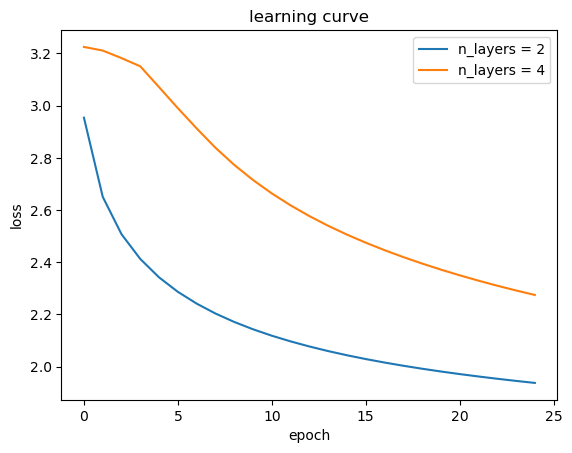

In [101]:
plt.plot(loss_per_epoch_train_6, label='n_layers = 2')
plt.plot(loss_per_epoch_train_7, label='n_layers = 4')
plt.title('learning curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.show()

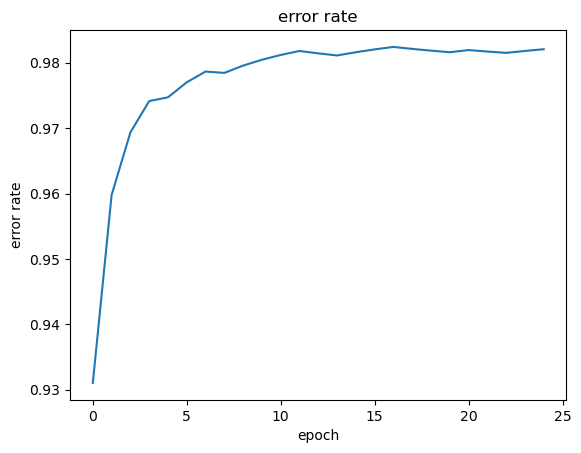

In [80]:
plt.plot(acc_per_epoch_train_6)
plt.title('error rate')
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.show()

In [87]:
model_name = 'RNN_net_7.pth'
checkpoint = {'n_hidden': net_7.n_hidden,
              'n_layers': net_7.n_layers,
              'state_dict': net_7.state_dict(),
              'tokens' : net_7.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

In [105]:
def predict(net, char, h = None):
    x = np.array([[net.char2int[char]]])
    x = one_hot_encode(x, len(net.chars))
    inputs = torch.from_numpy(x)
    
    out, h = net(inputs, h)
    h = h.detach()
    
    p = torch.nn.functional.softmax(out, dim =1).data

    return net.int2char[np.argmax(p).item()], h

def sample(net, size, prime='The'):
    net.eval() 
    chars = [ch for ch in prime]
    h = net.init_hidden(1)

    for ch in prime:
        char, h = predict(net, ch, h)
    chars.append(char)

    for ii in range(size):
        char, h = predict(net, chars[-1], h)
        chars.append(char)

    return ''.join(chars)
    

out = sample(net_5, 2000, prime='Fuck')
print(out)



Fuck of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the state of the state of the courtesy,The state of the 